In [ ]:
#Import libraries and loading annotations

import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import cv2
%matplotlib inline
import os
from pycocotools import mask as maskUtils
from tqdm import tqdm
from PIL import Image

In [ ]:
#Import and mount google drive

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Unzip the dataset file and store in a folder

!unzip -o "/content/drive/MyDrive/RM_Segmentation_Assignment_dataset.zip" -d "/content/drive/MyDrive/"

Archive:  /content/drive/MyDrive/RM_Segmentation_Assignment_dataset.zip
  inflating: /content/drive/MyDrive/test-30/000000001751.jpg  
  inflating: /content/drive/MyDrive/test-30/000000001380.jpg  
  inflating: /content/drive/MyDrive/test-30/000000001643.jpg  
  inflating: /content/drive/MyDrive/test-30/000000001583.jpg  
  inflating: /content/drive/MyDrive/test-30/000000001685.jpg  
  inflating: /content/drive/MyDrive/test-30/000000001482.jpg  
  inflating: /content/drive/MyDrive/test-30/000000001494.jpg  
  inflating: /content/drive/MyDrive/test-30/000000001551.jpg  
  inflating: /content/drive/MyDrive/test-30/000000001654.jpg  
  inflating: /content/drive/MyDrive/test-30/000000001594.jpg  
  inflating: /content/drive/MyDrive/test-30/000000001411.jpg  
  inflating: /content/drive/MyDrive/test-30/000000001459.jpg  
  inflating: /content/drive/MyDrive/test-30/000000001410.jpg  
  inflating: /content/drive/MyDrive/test-30/000000001717.jpg  
  inflating: /content/drive/MyDrive/test-30/00

In [ ]:
#Define dataset paths

train_data_path = "/content/drive/MyDrive/train-300/data"
val_data_path = "/content/drive/MyDrive/validation-300/"
test_data_path = "/content/drive/MyDrive/test-30/"

In [ ]:
#Load training annotations

from pycocotools.coco import COCO
train_annotation_file = "/content/drive/MyDrive/train-300/labels.json"
coco = COCO(train_annotation_file)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [ ]:
#List of category names

categories = coco.loadCats(coco.getCatIds())
cat_names = [cat['name'] for cat in categories]
print(cat_names)

['airplane', 'backpack', 'banana', 'baseball bat', 'baseball glove', 'bear', 'bench', 'bicycle', 'bird', 'boat', 'book', 'bottle', 'bowl', 'broccoli', 'bus', 'cake', 'car', 'carrot', 'cat', 'cell phone', 'chair', 'clock', 'cow', 'cup', 'dining table', 'dog', 'donut', 'elephant', 'fire hydrant', 'fork', 'frisbee', 'giraffe', 'handbag', 'horse', 'hot dog', 'kite', 'knife', 'laptop', 'motorcycle', 'oven', 'parking meter', 'person', 'pizza', 'potted plant', 'refrigerator', 'remote', 'sandwich', 'scissors', 'skateboard', 'skis', 'spoon', 'sports ball', 'stop sign', 'suitcase', 'surfboard', 'tennis racket', 'tie', 'traffic light', 'train', 'truck', 'umbrella', 'vase', 'wine glass']


**EDA**

In [ ]:
#Filter four target categories
target_classes = ['cake', 'car', 'dog', 'person']
target_cat_ids = coco.getCatIds(catNms=target_classes)

#Print segmentation for each class
print("Number of segmentations for each target class:")

for cat_name in target_classes:
    cat_id = coco.getCatIds(catNms=[cat_name])[0]
    ann_ids = coco.getAnnIds(catIds=[cat_id])
    print(f"{cat_name}: {len(ann_ids)} segmentations")

Number of segmentations for each target class:
cake: 13 segmentations
car: 1061 segmentations
dog: 14 segmentations
person: 1350 segmentations


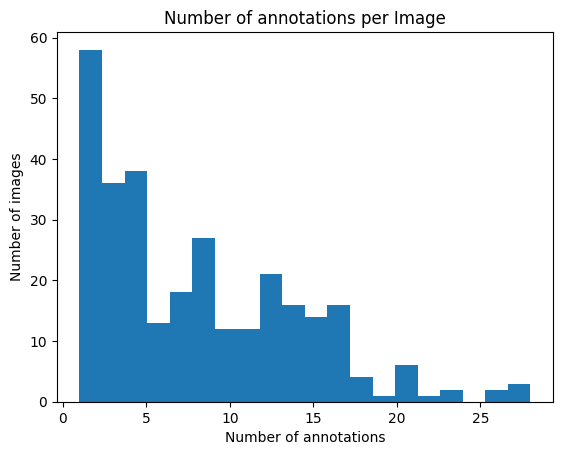

In [ ]:
#Distribution of annotations per image

ann_per_image = []
img_ids = coco.getImgIds()
for img_id in img_ids:
    ann_ids = coco.getAnnIds(imgIds=img_id, catIds=target_cat_ids)
    ann_per_image.append(len(ann_ids))

plt.hist(ann_per_image, bins=20)
plt.title("Number of annotations per Image")
plt.xlabel("Number of annotations")
plt.ylabel("Number of images")
plt.show()

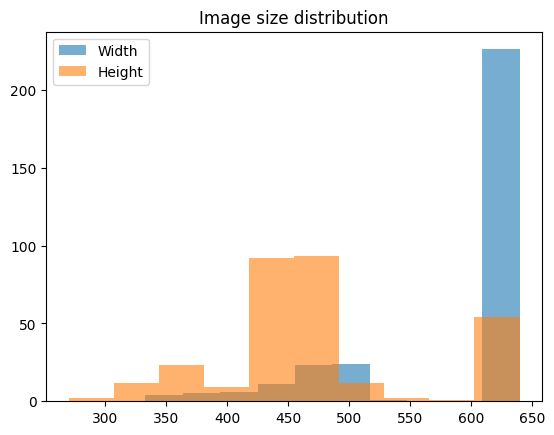

In [ ]:
#Image size distribution

size = []
for img_id in coco.getImgIds()[:800]:
    img_info = coco.loadImgs(img_id)[0]
    size.append((img_info['width'], img_info['height']))

size = np.array(size)
plt.hist(size[:, 0], bins=10, alpha=0.6, label='Width')
plt.hist(size[:, 1], bins=10, alpha=0.6, label='Height')
plt.legend()
plt.title("Image size distribution")
plt.show()

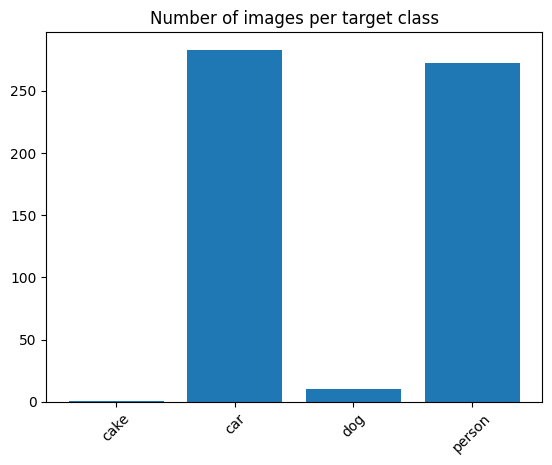

In [ ]:
#Class frequencies

class_counts = defaultdict(int)
for cid in target_cat_ids:
    class_name = coco.loadCats([cid])[0]['name']
    class_counts[class_name] = len(coco.getImgIds(catIds=[cid]))

plt.bar(class_counts.keys(), class_counts.values())
plt.title("Number of images per target class")
plt.xticks(rotation=45)
plt.show()

Found 300 images with at least one target category.


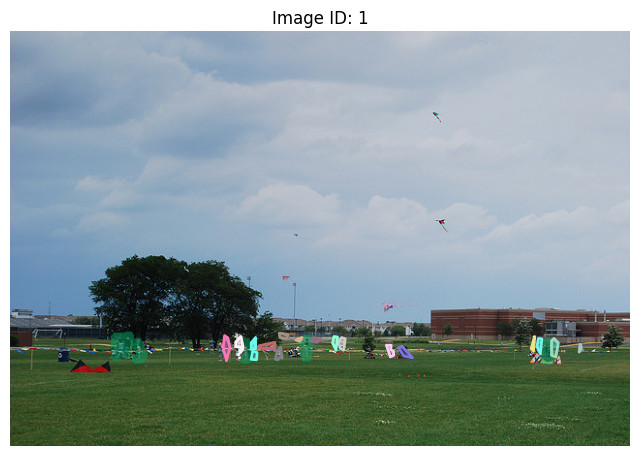

In [ ]:
#Visualize raw segmentation masks

#Get all annotation IDs for target categories
ann_ids = coco.getAnnIds(catIds=target_cat_ids)
anns = coco.loadAnns(ann_ids)

#Get unique image IDs from these annotations
target_img_ids = list(set([ann['image_id'] for ann in anns]))
print(f"Found {len(target_img_ids)} images with at least one target category.")

#Load and display first image with target class
if target_img_ids:
    img = coco.loadImgs(target_img_ids[0])[0]
    img_path = os.path.join("/content/drive/MyDrive/train-300/data", img['file_name'])

    if os.path.exists(img_path):
        I = io.imread(img_path)
        plt.figure(figsize=(8,6))
        plt.imshow(I)
        plt.axis('off')
        plt.title(f"Image ID: {img['id']}")
        ann_ids = coco.getAnnIds(imgIds=img['id'], catIds=target_cat_ids)
        anns = coco.loadAnns(ann_ids)
        coco.showAnns(anns)
        plt.show()
    else:
        print(f"Image file not found: {img_path}")
else:
    print("No images found for the target categories.")

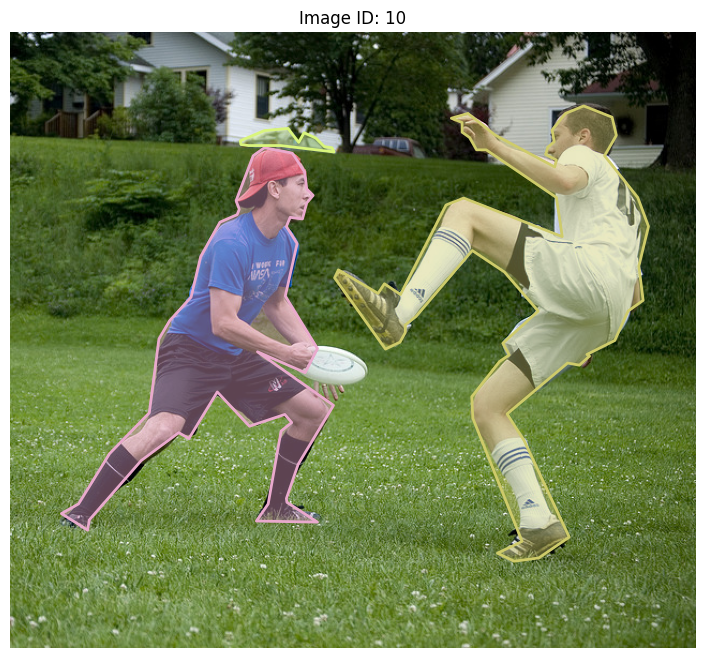

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

In [ ]:
#Choose an image ID
image_id = 10

img_info = coco.loadImgs(image_id)[0]
img_path = os.path.join(train_data_path, img_info['file_name'])

#Load image
image = io.imread(img_path)

#Load annotations for cake, car, dog, person
ann_ids = coco.getAnnIds(imgIds=image_id, catIds=target_cat_ids)
anns = coco.loadAnns(ann_ids)

plt.figure(figsize=(10, 8))
plt.imshow(image)
plt.title(f"Image ID: {image_id}")
plt.axis('off')

#Show colored boundaries
coco.showAnns(anns)

plt.show()

#Returns a list of available image IDs
print(coco.getImgIds())

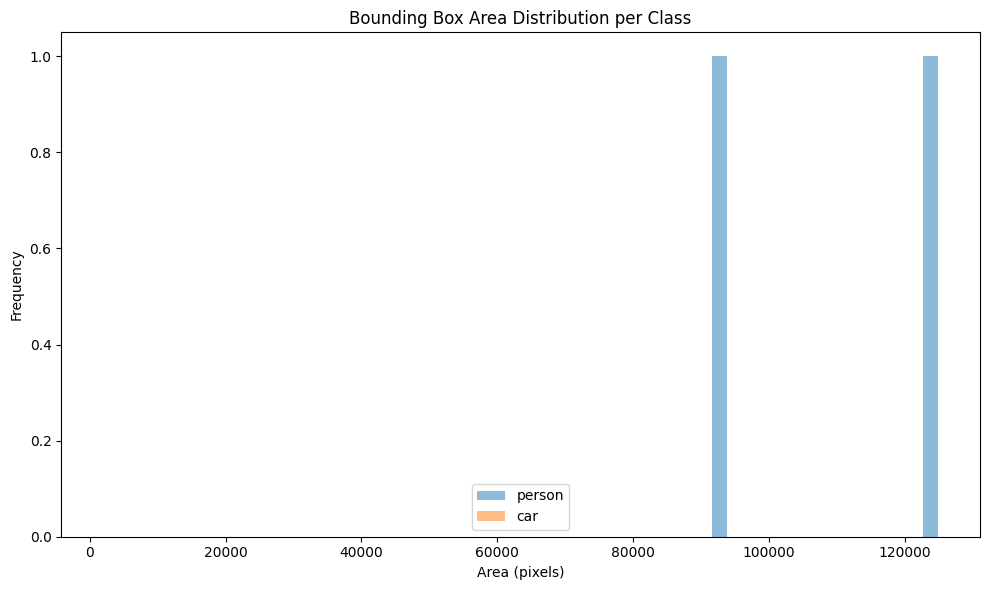

In [ ]:
#Bounding box distribution per class

category_area = defaultdict(list)

for ann in anns:
    cat_id = ann['category_id']
    cat_name = coco.loadCats([cat_id])[0]['name']
    area = ann['bbox'][2] * ann['bbox'][3]
    category_area[cat_name].append(area)

# Plot
plt.figure(figsize=(10, 6))
for cat, areas in category_area.items():
    if areas:
        plt.hist(areas, bins=15, alpha=0.5, label=cat)

plt.title("Bounding Box Area Distribution per Class")
plt.xlabel("Area (pixels)")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

Data preprocessing and Mask generating

In [ ]:
#Define directories for processed images and masks

output_img_dir = "/content/drive/MyDrive/preprocessed/images"
output_mask_dir = "/content/drive/MyDrive/preprocessed/masks"

#Create directories if they don't exist

os.makedirs(output_img_dir, exist_ok=True)
os.makedirs(output_mask_dir, exist_ok=True)


In [ ]:
#Mapping category ID to label index

category_id_label = {cat_id: idx + 1 for idx, cat_id in enumerate(target_cat_ids)}

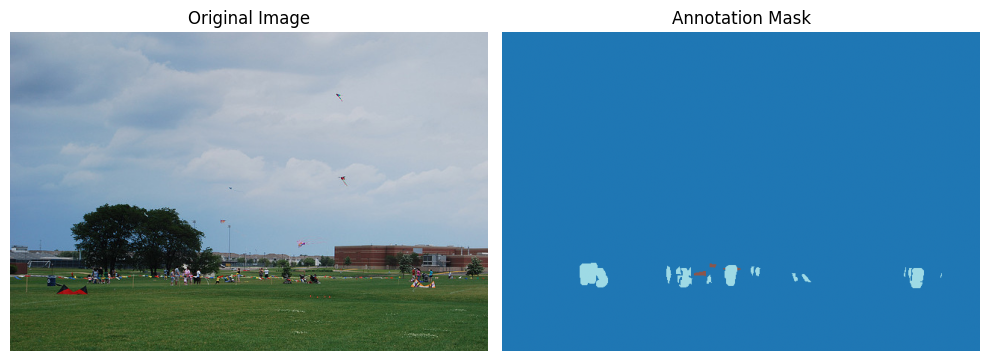

In [ ]:
#Check raw images and annotation mask

def sample_image_and_mask(img_id):
    img_info = coco.loadImgs(img_id)[0]
    img_path = os.path.join(train_data_path, img_info['file_name'])

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    #Create the mask
    height, width = image.shape[:2]
    mask = np.zeros((height, width), dtype=np.uint8)
    ann_ids = coco.getAnnIds(imgIds=img_id, catIds=target_cat_ids)
    anns = coco.loadAnns(ann_ids)

    for ann in anns:
        cat_id = ann['category_id']
        label = category_id_label.get(cat_id)
        if label is None:
            continue
        rle = coco.annToRLE(ann)
        binary_mask = maskUtils.decode(rle)
        mask[binary_mask == 1] = label

    #Print the image
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="tab20")
    plt.title("Annotation Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


sample_image_and_mask(target_img_ids[0])

In [ ]:
def process_target_images():
    for img_id in tqdm(target_img_ids[:300], desc="Generating masks"):
        img_info = coco.loadImgs(img_id)[0]
        img_path = os.path.join(train_data_path, img_info['file_name'])

        if not os.path.exists(img_path):
            continue

        #Load and convert image

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        height, width = image.shape[:2]

        #Create the blank mask
        mask = np.zeros((height, width), dtype=np.uint8)

        #Get annotations and add each to the mask
        ann_ids = coco.getAnnIds(imgIds=img_id, catIds=target_cat_ids)
        anns = coco.loadAnns(ann_ids)

        for ann in anns:
            cat_id = ann['category_id']
            label = category_id_label.get(cat_id)
            if label is None:
                continue
            rle = coco.annToRLE(ann)
            binary_mask = maskUtils.decode(rle)
            mask[binary_mask == 1] = label

        #Resize image and mask

        resized_image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_LINEAR)
        resized_mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)

        #Save processed image and mask

        base_name = os.path.splitext(img_info['file_name'])[0]
        img_save_path = os.path.join(output_img_dir, f"{base_name}.png")
        mask_save_path = os.path.join(output_mask_dir, f"{base_name}_mask.png")

        Image.fromarray(resized_image).save(img_save_path)
        Image.fromarray(resized_mask).save(mask_save_path)

        print(f"{img_info['file_name']}")

In [ ]:
process_target_images()

Generating masks:   0%|          | 1/300 [00:03<18:14,  3.66s/it]

000000000149.jpg


Generating masks:   1%|          | 2/300 [00:04<10:05,  2.03s/it]

000000000260.jpg


Generating masks:   1%|          | 3/300 [00:05<07:11,  1.45s/it]

000000000328.jpg


Generating masks:   1%|▏         | 4/300 [00:06<05:43,  1.16s/it]

000000000419.jpg


Generating masks:   2%|▏         | 5/300 [00:07<06:07,  1.25s/it]

000000000722.jpg


Generating masks:   2%|▏         | 6/300 [00:08<05:13,  1.06s/it]

000000000730.jpg


Generating masks:   2%|▏         | 7/300 [00:08<04:36,  1.06it/s]

000000000731.jpg


Generating masks:   3%|▎         | 8/300 [00:09<04:18,  1.13it/s]

000000000810.jpg


Generating masks:   3%|▎         | 9/300 [00:10<03:59,  1.22it/s]

000000000821.jpg


Generating masks:   3%|▎         | 10/300 [00:11<04:49,  1.00it/s]

000000000839.jpg


Generating masks:   4%|▎         | 11/300 [00:12<04:20,  1.11it/s]

000000000923.jpg


Generating masks:   4%|▍         | 12/300 [00:13<04:08,  1.16it/s]

000000001006.jpg


Generating masks:   4%|▍         | 13/300 [00:13<03:50,  1.24it/s]

000000001053.jpg


Generating masks:   5%|▍         | 14/300 [00:14<03:46,  1.26it/s]

000000001144.jpg


Generating masks:   5%|▌         | 15/300 [00:15<03:39,  1.30it/s]

000000001311.jpg


Generating masks:   5%|▌         | 16/300 [00:15<03:33,  1.33it/s]

000000001315.jpg


Generating masks:   6%|▌         | 17/300 [00:16<03:37,  1.30it/s]

000000001523.jpg


Generating masks:   6%|▌         | 18/300 [00:17<03:36,  1.31it/s]

000000001586.jpg


Generating masks:   6%|▋         | 19/300 [00:18<03:46,  1.24it/s]

000000001720.jpg


Generating masks:   7%|▋         | 20/300 [00:19<03:48,  1.23it/s]

000000001799.jpg


Generating masks:   7%|▋         | 21/300 [00:20<03:45,  1.24it/s]

000000001915.jpg


Generating masks:   7%|▋         | 22/300 [00:20<03:31,  1.31it/s]

000000001924.jpg


Generating masks:   8%|▊         | 23/300 [00:21<03:30,  1.31it/s]

000000001955.jpg


Generating masks:   8%|▊         | 24/300 [00:22<03:24,  1.35it/s]

000000002014.jpg


Generating masks:   8%|▊         | 25/300 [00:22<03:22,  1.36it/s]

000000002089.jpg


Generating masks:   9%|▊         | 26/300 [00:23<03:23,  1.35it/s]

000000002142.jpg


Generating masks:   9%|▉         | 27/300 [00:24<03:17,  1.38it/s]

000000002154.jpg


Generating masks:   9%|▉         | 28/300 [00:25<03:12,  1.42it/s]

000000002281.jpg


Generating masks:  10%|▉         | 29/300 [00:25<03:14,  1.39it/s]

000000002459.jpg


Generating masks:  10%|█         | 30/300 [00:26<03:09,  1.42it/s]

000000002644.jpg


Generating masks:  10%|█         | 31/300 [00:27<03:07,  1.44it/s]

000000002687.jpg


Generating masks:  11%|█         | 32/300 [00:28<03:38,  1.23it/s]

000000002754.jpg


Generating masks:  11%|█         | 33/300 [00:28<03:33,  1.25it/s]

000000002774.jpg


Generating masks:  11%|█▏        | 34/300 [00:29<03:25,  1.29it/s]

000000002782.jpg


Generating masks:  12%|█▏        | 35/300 [00:30<03:30,  1.26it/s]

000000002860.jpg


Generating masks:  12%|█▏        | 36/300 [00:31<03:32,  1.24it/s]

000000002890.jpg


Generating masks:  12%|█▏        | 37/300 [00:32<03:30,  1.25it/s]

000000002951.jpg


Generating masks:  13%|█▎        | 38/300 [00:32<03:24,  1.28it/s]

000000002998.jpg


Generating masks:  13%|█▎        | 39/300 [00:33<03:18,  1.31it/s]

000000003160.jpg


Generating masks:  13%|█▎        | 40/300 [00:34<03:11,  1.35it/s]

000000003272.jpg


Generating masks:  14%|█▎        | 41/300 [00:35<03:17,  1.31it/s]

000000003337.jpg


Generating masks:  14%|█▍        | 42/300 [00:35<03:21,  1.28it/s]

000000003493.jpg


Generating masks:  14%|█▍        | 43/300 [00:36<03:16,  1.31it/s]

000000003535.jpg


Generating masks:  15%|█▍        | 44/300 [00:37<03:11,  1.34it/s]

000000003590.jpg


Generating masks:  15%|█▌        | 45/300 [00:38<03:15,  1.30it/s]

000000003602.jpg


Generating masks:  15%|█▌        | 46/300 [00:38<03:13,  1.31it/s]

000000003817.jpg


Generating masks:  16%|█▌        | 47/300 [00:39<03:05,  1.37it/s]

000000003830.jpg


Generating masks:  16%|█▌        | 48/300 [00:40<03:08,  1.34it/s]

000000003988.jpg


Generating masks:  16%|█▋        | 49/300 [00:41<03:16,  1.28it/s]

000000004020.jpg


Generating masks:  17%|█▋        | 50/300 [00:41<03:10,  1.31it/s]

000000004130.jpg


Generating masks:  17%|█▋        | 51/300 [00:42<03:12,  1.29it/s]

000000004246.jpg


Generating masks:  17%|█▋        | 52/300 [00:43<03:07,  1.32it/s]

000000004275.jpg


Generating masks:  18%|█▊        | 53/300 [00:44<03:01,  1.36it/s]

000000004289.jpg


Generating masks:  18%|█▊        | 54/300 [00:44<02:56,  1.40it/s]

000000004355.jpg


Generating masks:  18%|█▊        | 55/300 [00:45<02:53,  1.42it/s]

000000004360.jpg


Generating masks:  19%|█▊        | 56/300 [00:46<02:54,  1.40it/s]

000000004376.jpg


Generating masks:  19%|█▉        | 57/300 [00:46<02:53,  1.40it/s]

000000004377.jpg


Generating masks:  19%|█▉        | 58/300 [00:47<02:52,  1.41it/s]

000000004404.jpg


Generating masks:  20%|█▉        | 59/300 [00:48<02:52,  1.40it/s]

000000004489.jpg


Generating masks:  20%|██        | 60/300 [00:49<02:47,  1.44it/s]

000000004502.jpg


Generating masks:  20%|██        | 61/300 [00:49<02:53,  1.37it/s]

000000004551.jpg


Generating masks:  21%|██        | 62/300 [00:50<03:23,  1.17it/s]

000000004578.jpg


Generating masks:  21%|██        | 63/300 [00:51<03:20,  1.18it/s]

000000004595.jpg


Generating masks:  21%|██▏       | 64/300 [00:52<03:07,  1.26it/s]

000000004665.jpg


Generating masks:  22%|██▏       | 65/300 [00:53<03:00,  1.30it/s]

000000004700.jpg


Generating masks:  22%|██▏       | 66/300 [00:53<02:52,  1.35it/s]

000000004736.jpg


Generating masks:  22%|██▏       | 67/300 [00:54<02:56,  1.32it/s]

000000004968.jpg


Generating masks:  23%|██▎       | 68/300 [00:55<02:50,  1.36it/s]

000000004988.jpg


Generating masks:  23%|██▎       | 69/300 [00:56<02:47,  1.38it/s]

000000005018.jpg


Generating masks:  23%|██▎       | 70/300 [00:56<02:51,  1.34it/s]

000000005073.jpg


Generating masks:  24%|██▎       | 71/300 [00:57<02:47,  1.37it/s]

000000005105.jpg


Generating masks:  24%|██▍       | 72/300 [00:58<03:12,  1.19it/s]

000000005107.jpg


Generating masks:  24%|██▍       | 73/300 [00:59<03:06,  1.22it/s]

000000005156.jpg


Generating masks:  25%|██▍       | 74/300 [01:00<03:03,  1.23it/s]

000000005205.jpg


Generating masks:  25%|██▌       | 75/300 [01:01<03:09,  1.19it/s]

000000005256.jpg


Generating masks:  25%|██▌       | 76/300 [01:01<03:00,  1.24it/s]

000000005282.jpg


Generating masks:  26%|██▌       | 77/300 [01:02<02:52,  1.29it/s]

000000005294.jpg


Generating masks:  26%|██▌       | 78/300 [01:03<02:49,  1.31it/s]

000000005325.jpg


Generating masks:  26%|██▋       | 79/300 [01:04<02:50,  1.30it/s]

000000005336.jpg


Generating masks:  27%|██▋       | 80/300 [01:04<02:57,  1.24it/s]

000000005394.jpg


Generating masks:  27%|██▋       | 81/300 [01:06<03:16,  1.11it/s]

000000005601.jpg


Generating masks:  27%|██▋       | 82/300 [01:06<03:06,  1.17it/s]

000000005620.jpg


Generating masks:  28%|██▊       | 83/300 [01:07<02:56,  1.23it/s]

000000005684.jpg


Generating masks:  28%|██▊       | 84/300 [01:08<02:43,  1.32it/s]

000000005756.jpg


Generating masks:  28%|██▊       | 85/300 [01:08<02:35,  1.38it/s]

000000005769.jpg


Generating masks:  29%|██▊       | 86/300 [01:09<02:31,  1.41it/s]

000000006004.jpg


Generating masks:  29%|██▉       | 87/300 [01:10<03:05,  1.15it/s]

000000006233.jpg


Generating masks:  29%|██▉       | 88/300 [01:11<02:55,  1.21it/s]

000000006414.jpg


Generating masks:  30%|██▉       | 89/300 [01:12<02:49,  1.24it/s]

000000006517.jpg


Generating masks:  30%|███       | 90/300 [01:13<02:50,  1.23it/s]

000000006522.jpg


Generating masks:  30%|███       | 91/300 [01:13<02:47,  1.25it/s]

000000006531.jpg


Generating masks:  31%|███       | 92/300 [01:14<02:42,  1.28it/s]

000000006562.jpg


Generating masks:  31%|███       | 93/300 [01:15<02:36,  1.32it/s]

000000006602.jpg


Generating masks:  31%|███▏      | 94/300 [01:15<02:35,  1.33it/s]

000000006709.jpg


Generating masks:  32%|███▏      | 95/300 [01:16<02:29,  1.37it/s]

000000006789.jpg


Generating masks:  32%|███▏      | 96/300 [01:17<02:23,  1.42it/s]

000000006811.jpg


Generating masks:  32%|███▏      | 97/300 [01:17<02:21,  1.43it/s]

000000006935.jpg


Generating masks:  33%|███▎      | 98/300 [01:18<02:19,  1.45it/s]

000000007104.jpg


Generating masks:  33%|███▎      | 99/300 [01:19<02:26,  1.37it/s]

000000007124.jpg


Generating masks:  33%|███▎      | 100/300 [01:20<02:25,  1.38it/s]

000000007178.jpg


Generating masks:  34%|███▎      | 101/300 [01:20<02:22,  1.40it/s]

000000007201.jpg


Generating masks:  34%|███▍      | 102/300 [01:21<02:44,  1.21it/s]

000000007228.jpg


Generating masks:  34%|███▍      | 103/300 [01:22<02:38,  1.25it/s]

000000007297.jpg


Generating masks:  35%|███▍      | 104/300 [01:23<02:27,  1.33it/s]

000000007298.jpg


Generating masks:  35%|███▌      | 105/300 [01:24<02:25,  1.34it/s]

000000007325.jpg


Generating masks:  35%|███▌      | 106/300 [01:24<02:33,  1.26it/s]

000000007650.jpg


Generating masks:  36%|███▌      | 107/300 [01:25<02:29,  1.29it/s]

000000007685.jpg


Generating masks:  36%|███▌      | 108/300 [01:26<02:22,  1.34it/s]

000000007726.jpg


Generating masks:  36%|███▋      | 109/300 [01:27<02:48,  1.14it/s]

000000007819.jpg


Generating masks:  37%|███▋      | 110/300 [01:28<02:38,  1.20it/s]

000000007938.jpg


Generating masks:  37%|███▋      | 111/300 [01:29<02:29,  1.26it/s]

000000008019.jpg


Generating masks:  37%|███▋      | 112/300 [01:29<02:25,  1.29it/s]

000000008025.jpg


Generating masks:  38%|███▊      | 113/300 [01:30<02:21,  1.32it/s]

000000008086.jpg


Generating masks:  38%|███▊      | 114/300 [01:31<02:19,  1.33it/s]

000000008187.jpg


Generating masks:  38%|███▊      | 115/300 [01:31<02:11,  1.41it/s]

000000008309.jpg


Generating masks:  39%|███▊      | 116/300 [01:32<02:12,  1.39it/s]

000000008339.jpg


Generating masks:  39%|███▉      | 117/300 [01:33<02:06,  1.45it/s]

000000008593.jpg


Generating masks:  39%|███▉      | 118/300 [01:33<02:09,  1.41it/s]

000000008834.jpg


Generating masks:  40%|███▉      | 119/300 [01:34<02:04,  1.45it/s]

000000008965.jpg


Generating masks:  40%|████      | 120/300 [01:35<02:05,  1.43it/s]

000000009112.jpg


Generating masks:  40%|████      | 121/300 [01:35<02:04,  1.44it/s]

000000009133.jpg


Generating masks:  41%|████      | 122/300 [01:36<02:05,  1.42it/s]

000000009274.jpg


Generating masks:  41%|████      | 123/300 [01:37<02:17,  1.29it/s]

000000009286.jpg


Generating masks:  41%|████▏     | 124/300 [01:38<02:14,  1.30it/s]

000000009317.jpg


Generating masks:  42%|████▏     | 125/300 [01:39<02:19,  1.25it/s]

000000009379.jpg


Generating masks:  42%|████▏     | 126/300 [01:40<02:20,  1.24it/s]

000000009488.jpg


Generating masks:  42%|████▏     | 127/300 [01:40<02:20,  1.23it/s]

000000009542.jpg


Generating masks:  43%|████▎     | 128/300 [01:41<02:14,  1.27it/s]

000000009572.jpg


Generating masks:  43%|████▎     | 129/300 [01:42<02:12,  1.29it/s]

000000009615.jpg


Generating masks:  43%|████▎     | 130/300 [01:43<02:10,  1.30it/s]

000000009647.jpg


Generating masks:  44%|████▎     | 131/300 [01:43<02:07,  1.32it/s]

000000009648.jpg


Generating masks:  44%|████▍     | 132/300 [01:44<02:12,  1.27it/s]

000000009801.jpg


Generating masks:  44%|████▍     | 133/300 [01:45<02:22,  1.17it/s]

000000009885.jpg


Generating masks:  45%|████▍     | 134/300 [01:46<02:31,  1.10it/s]

000000009941.jpg


Generating masks:  45%|████▌     | 135/300 [01:47<02:19,  1.18it/s]

000000009999.jpg


Generating masks:  45%|████▌     | 136/300 [01:48<02:28,  1.11it/s]

000000010014.jpg


Generating masks:  46%|████▌     | 137/300 [01:49<02:18,  1.18it/s]

000000010056.jpg


Generating masks:  46%|████▌     | 138/300 [01:49<02:11,  1.23it/s]

000000010318.jpg


Generating masks:  46%|████▋     | 139/300 [01:50<02:06,  1.27it/s]

000000010393.jpg


Generating masks:  47%|████▋     | 140/300 [01:51<02:04,  1.29it/s]

000000010434.jpg


Generating masks:  47%|████▋     | 141/300 [01:52<02:01,  1.31it/s]

000000010545.jpg


Generating masks:  47%|████▋     | 142/300 [01:52<01:57,  1.34it/s]

000000010613.jpg


Generating masks:  48%|████▊     | 143/300 [01:53<01:58,  1.33it/s]

000000010615.jpg


Generating masks:  48%|████▊     | 144/300 [01:54<01:52,  1.39it/s]

000000010639.jpg


Generating masks:  48%|████▊     | 145/300 [01:55<02:02,  1.27it/s]

000000010693.jpg


Generating masks:  49%|████▊     | 146/300 [01:55<01:59,  1.29it/s]

000000010732.jpg


Generating masks:  49%|████▉     | 147/300 [01:56<01:57,  1.31it/s]

000000010825.jpg


Generating masks:  49%|████▉     | 148/300 [01:57<01:53,  1.34it/s]

000000010837.jpg


Generating masks:  50%|████▉     | 149/300 [01:58<01:52,  1.34it/s]

000000010920.jpg


Generating masks:  50%|█████     | 150/300 [01:58<01:48,  1.39it/s]

000000011065.jpg


Generating masks:  50%|█████     | 151/300 [01:59<01:50,  1.35it/s]

000000011138.jpg


Generating masks:  51%|█████     | 152/300 [02:00<01:46,  1.40it/s]

000000011159.jpg


Generating masks:  51%|█████     | 153/300 [02:00<01:42,  1.43it/s]

000000011182.jpg


Generating masks:  51%|█████▏    | 154/300 [02:01<01:42,  1.43it/s]

000000011258.jpg


Generating masks:  52%|█████▏    | 155/300 [02:02<01:49,  1.33it/s]

000000011264.jpg


Generating masks:  52%|█████▏    | 156/300 [02:03<01:57,  1.23it/s]

000000011265.jpg


Generating masks:  52%|█████▏    | 157/300 [02:04<01:54,  1.25it/s]

000000011340.jpg


Generating masks:  53%|█████▎    | 158/300 [02:05<01:52,  1.27it/s]

000000011402.jpg


Generating masks:  53%|█████▎    | 159/300 [02:06<01:59,  1.18it/s]

000000011426.jpg


Generating masks:  53%|█████▎    | 160/300 [02:06<02:02,  1.15it/s]

000000011569.jpg


Generating masks:  54%|█████▎    | 161/300 [02:07<01:55,  1.20it/s]

000000011579.jpg


Generating masks:  54%|█████▍    | 162/300 [02:09<02:38,  1.15s/it]

000000011619.jpg


Generating masks:  54%|█████▍    | 163/300 [02:13<04:22,  1.92s/it]

000000011624.jpg


Generating masks:  55%|█████▍    | 164/300 [02:14<03:43,  1.64s/it]

000000011690.jpg


Generating masks:  55%|█████▌    | 165/300 [02:15<03:05,  1.38s/it]

000000011788.jpg


Generating masks:  55%|█████▌    | 166/300 [02:15<02:37,  1.17s/it]

000000011838.jpg


Generating masks:  56%|█████▌    | 167/300 [02:20<05:06,  2.30s/it]

000000011968.jpg


Generating masks:  56%|█████▌    | 168/300 [02:21<04:00,  1.82s/it]

000000012020.jpg


Generating masks:  56%|█████▋    | 169/300 [02:22<03:16,  1.50s/it]

000000012093.jpg


Generating masks:  57%|█████▋    | 170/300 [02:22<02:41,  1.25s/it]

000000012108.jpg


Generating masks:  57%|█████▋    | 171/300 [02:23<02:22,  1.10s/it]

000000012109.jpg


Generating masks:  57%|█████▋    | 172/300 [02:24<02:07,  1.00it/s]

000000012131.jpg


Generating masks:  58%|█████▊    | 173/300 [02:24<01:55,  1.10it/s]

000000012145.jpg


Generating masks:  58%|█████▊    | 174/300 [02:25<01:49,  1.15it/s]

000000012230.jpg


Generating masks:  58%|█████▊    | 175/300 [02:26<01:43,  1.21it/s]

000000012238.jpg


Generating masks:  59%|█████▊    | 176/300 [02:27<01:44,  1.19it/s]

000000012283.jpg


Generating masks:  59%|█████▉    | 177/300 [02:28<01:43,  1.19it/s]

000000012370.jpg


Generating masks:  59%|█████▉    | 178/300 [02:29<01:41,  1.20it/s]

000000012418.jpg


Generating masks:  60%|█████▉    | 179/300 [02:30<01:46,  1.13it/s]

000000012544.jpg


Generating masks:  60%|██████    | 180/300 [02:30<01:42,  1.17it/s]

000000012666.jpg


Generating masks:  60%|██████    | 181/300 [02:31<01:37,  1.22it/s]

000000012726.jpg


Generating masks:  61%|██████    | 182/300 [02:32<01:31,  1.29it/s]

000000012818.jpg


Generating masks:  61%|██████    | 183/300 [02:33<01:32,  1.27it/s]

000000012861.jpg


Generating masks:  61%|██████▏   | 184/300 [02:33<01:28,  1.31it/s]

000000012891.jpg


Generating masks:  62%|██████▏   | 185/300 [02:34<01:34,  1.22it/s]

000000012946.jpg


Generating masks:  62%|██████▏   | 186/300 [02:35<01:31,  1.24it/s]

000000012993.jpg


Generating masks:  62%|██████▏   | 187/300 [02:36<01:27,  1.29it/s]

000000013082.jpg


Generating masks:  63%|██████▎   | 188/300 [02:37<01:35,  1.18it/s]

000000013143.jpg


Generating masks:  63%|██████▎   | 189/300 [02:37<01:31,  1.22it/s]

000000013172.jpg


Generating masks:  63%|██████▎   | 190/300 [02:39<01:38,  1.12it/s]

000000013198.jpg


Generating masks:  64%|██████▎   | 191/300 [02:39<01:30,  1.21it/s]

000000013230.jpg


Generating masks:  64%|██████▍   | 192/300 [02:40<01:27,  1.24it/s]

000000013258.jpg


Generating masks:  64%|██████▍   | 193/300 [02:41<01:24,  1.27it/s]

000000013274.jpg


Generating masks:  65%|██████▍   | 194/300 [02:41<01:22,  1.29it/s]

000000013290.jpg


Generating masks:  65%|██████▌   | 195/300 [02:42<01:19,  1.32it/s]

000000013296.jpg


Generating masks:  65%|██████▌   | 196/300 [02:43<01:19,  1.30it/s]

000000013325.jpg


Generating masks:  66%|██████▌   | 197/300 [02:44<01:23,  1.23it/s]

000000013379.jpg


Generating masks:  66%|██████▌   | 198/300 [02:45<01:18,  1.30it/s]

000000013489.jpg


Generating masks:  66%|██████▋   | 199/300 [02:45<01:16,  1.33it/s]

000000013576.jpg


Generating masks:  67%|██████▋   | 200/300 [02:46<01:19,  1.26it/s]

000000013720.jpg


Generating masks:  67%|██████▋   | 201/300 [02:47<01:19,  1.25it/s]

000000013815.jpg


Generating masks:  67%|██████▋   | 202/300 [02:48<01:14,  1.31it/s]

000000013867.jpg


Generating masks:  68%|██████▊   | 203/300 [02:48<01:10,  1.37it/s]

000000013909.jpg


Generating masks:  68%|██████▊   | 204/300 [02:49<01:09,  1.38it/s]

000000013944.jpg


Generating masks:  68%|██████▊   | 205/300 [02:50<01:11,  1.34it/s]

000000014128.jpg


Generating masks:  69%|██████▊   | 206/300 [02:50<01:08,  1.36it/s]

000000014152.jpg


Generating masks:  69%|██████▉   | 207/300 [02:51<01:07,  1.39it/s]

000000014244.jpg


Generating masks:  69%|██████▉   | 208/300 [02:52<01:06,  1.39it/s]

000000014257.jpg


Generating masks:  70%|██████▉   | 209/300 [02:53<01:06,  1.38it/s]

000000014278.jpg


Generating masks:  70%|███████   | 210/300 [02:53<01:05,  1.37it/s]

000000014312.jpg


Generating masks:  70%|███████   | 211/300 [02:54<01:05,  1.36it/s]

000000014375.jpg


Generating masks:  71%|███████   | 212/300 [02:55<01:04,  1.36it/s]

000000014388.jpg


Generating masks:  71%|███████   | 213/300 [02:56<01:03,  1.37it/s]

000000014392.jpg


Generating masks:  71%|███████▏  | 214/300 [02:56<01:02,  1.37it/s]

000000014698.jpg


Generating masks:  72%|███████▏  | 215/300 [02:57<01:05,  1.31it/s]

000000014757.jpg


Generating masks:  72%|███████▏  | 216/300 [02:58<01:02,  1.34it/s]

000000014768.jpg


Generating masks:  72%|███████▏  | 217/300 [02:59<01:01,  1.35it/s]

000000014876.jpg


Generating masks:  73%|███████▎  | 218/300 [02:59<00:59,  1.39it/s]

000000014886.jpg


Generating masks:  73%|███████▎  | 219/300 [03:00<00:58,  1.38it/s]

000000014985.jpg


Generating masks:  73%|███████▎  | 220/300 [03:01<00:58,  1.38it/s]

000000014986.jpg


Generating masks:  74%|███████▎  | 221/300 [03:01<00:56,  1.41it/s]

000000015069.jpg


Generating masks:  74%|███████▍  | 222/300 [03:02<00:56,  1.37it/s]

000000015110.jpg


Generating masks:  74%|███████▍  | 223/300 [03:03<00:57,  1.33it/s]

000000015153.jpg


Generating masks:  75%|███████▍  | 224/300 [03:04<00:57,  1.32it/s]

000000015157.jpg


Generating masks:  75%|███████▌  | 225/300 [03:04<00:55,  1.36it/s]

000000015198.jpg


Generating masks:  75%|███████▌  | 226/300 [03:05<00:55,  1.34it/s]

000000015276.jpg


Generating masks:  76%|███████▌  | 227/300 [03:06<00:52,  1.38it/s]

000000015289.jpg


Generating masks:  76%|███████▌  | 228/300 [03:07<00:52,  1.38it/s]

000000015356.jpg


Generating masks:  76%|███████▋  | 229/300 [03:07<00:51,  1.38it/s]

000000015409.jpg


Generating masks:  77%|███████▋  | 230/300 [03:08<00:49,  1.41it/s]

000000015451.jpg


Generating masks:  77%|███████▋  | 231/300 [03:09<00:49,  1.41it/s]

000000015554.jpg


Generating masks:  77%|███████▋  | 232/300 [03:10<00:51,  1.32it/s]

000000015652.jpg


Generating masks:  78%|███████▊  | 233/300 [03:11<00:54,  1.22it/s]

000000015663.jpg


Generating masks:  78%|███████▊  | 234/300 [03:11<00:51,  1.28it/s]

000000015885.jpg


Generating masks:  78%|███████▊  | 235/300 [03:12<00:51,  1.27it/s]

000000015902.jpg


Generating masks:  79%|███████▊  | 236/300 [03:13<00:48,  1.32it/s]

000000015919.jpg


Generating masks:  79%|███████▉  | 237/300 [03:14<00:49,  1.28it/s]

000000016039.jpg


Generating masks:  79%|███████▉  | 238/300 [03:14<00:46,  1.33it/s]

000000016060.jpg


Generating masks:  80%|███████▉  | 239/300 [03:15<00:49,  1.24it/s]

000000016076.jpg


Generating masks:  80%|████████  | 240/300 [03:16<00:48,  1.25it/s]

000000016254.jpg


Generating masks:  80%|████████  | 241/300 [03:17<00:45,  1.31it/s]

000000016285.jpg


Generating masks:  81%|████████  | 242/300 [03:17<00:43,  1.34it/s]

000000016346.jpg


Generating masks:  81%|████████  | 243/300 [03:18<00:43,  1.31it/s]

000000016356.jpg


Generating masks:  81%|████████▏ | 244/300 [03:19<00:45,  1.24it/s]

000000016403.jpg


Generating masks:  82%|████████▏ | 245/300 [03:20<00:43,  1.28it/s]

000000016412.jpg


Generating masks:  82%|████████▏ | 246/300 [03:20<00:40,  1.33it/s]

000000016513.jpg


Generating masks:  82%|████████▏ | 247/300 [03:21<00:39,  1.33it/s]

000000016578.jpg


Generating masks:  83%|████████▎ | 248/300 [03:22<00:37,  1.38it/s]

000000016599.jpg


Generating masks:  83%|████████▎ | 249/300 [03:23<00:37,  1.35it/s]

000000016616.jpg


Generating masks:  83%|████████▎ | 250/300 [03:23<00:37,  1.33it/s]

000000016665.jpg


Generating masks:  84%|████████▎ | 251/300 [03:24<00:36,  1.35it/s]

000000016672.jpg


Generating masks:  84%|████████▍ | 252/300 [03:25<00:35,  1.35it/s]

000000016737.jpg


Generating masks:  84%|████████▍ | 253/300 [03:26<00:34,  1.37it/s]

000000016961.jpg


Generating masks:  85%|████████▍ | 254/300 [03:26<00:34,  1.33it/s]

000000016977.jpg


Generating masks:  85%|████████▌ | 255/300 [03:27<00:32,  1.37it/s]

000000534763.jpg


Generating masks:  85%|████████▌ | 256/300 [03:28<00:32,  1.37it/s]

000000000064.jpg


Generating masks:  86%|████████▌ | 257/300 [03:29<00:31,  1.36it/s]

000000000071.jpg


Generating masks:  86%|████████▌ | 258/300 [03:29<00:31,  1.34it/s]

000000000094.jpg


Generating masks:  86%|████████▋ | 259/300 [03:30<00:29,  1.37it/s]

000000000110.jpg


Generating masks:  87%|████████▋ | 260/300 [03:31<00:28,  1.41it/s]

000000000247.jpg


Generating masks:  87%|████████▋ | 261/300 [03:31<00:28,  1.38it/s]

000000000307.jpg


Generating masks:  87%|████████▋ | 262/300 [03:32<00:27,  1.39it/s]

000000000359.jpg


Generating masks:  88%|████████▊ | 263/300 [03:33<00:25,  1.44it/s]

000000000397.jpg


Generating masks:  88%|████████▊ | 264/300 [03:34<00:25,  1.39it/s]

000000000471.jpg


Generating masks:  88%|████████▊ | 265/300 [03:34<00:24,  1.43it/s]

000000000532.jpg


Generating masks:  89%|████████▊ | 266/300 [03:35<00:24,  1.41it/s]

000000000540.jpg


Generating masks:  89%|████████▉ | 267/300 [03:36<00:23,  1.39it/s]

000000000641.jpg


Generating masks:  89%|████████▉ | 268/300 [03:36<00:22,  1.44it/s]

000000000650.jpg


Generating masks:  90%|████████▉ | 269/300 [03:37<00:22,  1.38it/s]

000000000656.jpg


Generating masks:  90%|█████████ | 270/300 [03:38<00:20,  1.44it/s]

000000000775.jpg


Generating masks:  90%|█████████ | 271/300 [03:39<00:22,  1.28it/s]

000000000985.jpg


Generating masks:  91%|█████████ | 272/300 [03:39<00:21,  1.32it/s]

000000001171.jpg


Generating masks:  91%|█████████ | 273/300 [03:40<00:20,  1.30it/s]

000000001307.jpg


Generating masks:  91%|█████████▏| 274/300 [03:41<00:20,  1.30it/s]

000000001366.jpg


Generating masks:  92%|█████████▏| 275/300 [03:42<00:18,  1.34it/s]

000000001374.jpg


Generating masks:  92%|█████████▏| 276/300 [03:42<00:17,  1.35it/s]

000000001408.jpg


Generating masks:  92%|█████████▏| 277/300 [03:43<00:16,  1.37it/s]

000000001518.jpg


Generating masks:  93%|█████████▎| 278/300 [03:44<00:15,  1.38it/s]

000000001536.jpg


Generating masks:  93%|█████████▎| 279/300 [03:45<00:16,  1.29it/s]

000000001709.jpg


Generating masks:  93%|█████████▎| 280/300 [03:45<00:14,  1.33it/s]

000000001762.jpg


Generating masks:  94%|█████████▎| 281/300 [03:46<00:14,  1.35it/s]

000000001875.jpg


Generating masks:  94%|█████████▍| 282/300 [03:47<00:15,  1.18it/s]

000000002209.jpg


Generating masks:  94%|█████████▍| 283/300 [03:48<00:15,  1.13it/s]

000000002309.jpg


Generating masks:  95%|█████████▍| 284/300 [03:49<00:13,  1.16it/s]

000000002529.jpg


Generating masks:  95%|█████████▌| 285/300 [03:50<00:12,  1.23it/s]

000000002639.jpg


Generating masks:  95%|█████████▌| 286/300 [03:50<00:10,  1.30it/s]

000000002640.jpg


Generating masks:  96%|█████████▌| 287/300 [03:51<00:10,  1.26it/s]

000000002742.jpg


Generating masks:  96%|█████████▌| 288/300 [03:52<00:09,  1.27it/s]

000000002822.jpg


Generating masks:  96%|█████████▋| 289/300 [03:53<00:08,  1.26it/s]

000000002985.jpg


Generating masks:  97%|█████████▋| 290/300 [03:54<00:07,  1.28it/s]

000000003035.jpg


Generating masks:  97%|█████████▋| 291/300 [03:54<00:06,  1.33it/s]

000000003134.jpg


Generating masks:  97%|█████████▋| 292/300 [03:55<00:05,  1.38it/s]

000000003148.jpg


Generating masks:  98%|█████████▊| 293/300 [03:56<00:05,  1.38it/s]

000000003668.jpg


Generating masks:  98%|█████████▊| 294/300 [03:56<00:04,  1.41it/s]

000000003711.jpg


Generating masks:  98%|█████████▊| 295/300 [03:57<00:03,  1.45it/s]

000000003793.jpg


Generating masks:  99%|█████████▊| 296/300 [03:58<00:02,  1.44it/s]

000000003804.jpg


Generating masks:  99%|█████████▉| 297/300 [03:59<00:02,  1.31it/s]

000000003849.jpg


Generating masks:  99%|█████████▉| 298/300 [03:59<00:01,  1.35it/s]

000000003911.jpg


Generating masks: 100%|█████████▉| 299/300 [04:00<00:00,  1.37it/s]

000000003935.jpg


Generating masks: 100%|██████████| 300/300 [04:01<00:00,  1.24it/s]

000000003983.jpg


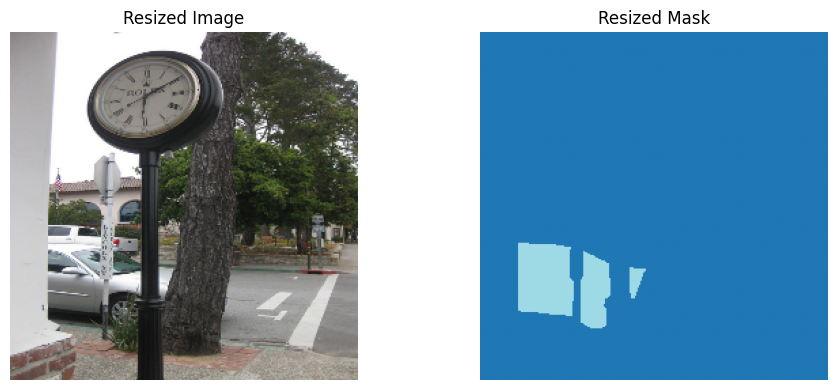

In [ ]:
#Show preprocessed image and mask
def preprocessed_image():
    img_files = sorted(os.listdir(output_img_dir))
    mask_files = sorted(os.listdir(output_mask_dir))

    img = Image.open(os.path.join(output_img_dir, img_files[0]))
    mask = Image.open(os.path.join(output_mask_dir, mask_files[0]))

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Resized Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="tab20")
    plt.title("Resized Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

preprocessed_image()

Model selection and setup

In [ ]:
import torch
import torch.nn as nn
import torchvision.models.segmentation as models

#Number of classes (4 target classes and 1 background)
Num_Classes = 5

#Load DeepLabV3 with a ResNet-50 backbone

model = models.deeplabv3_resnet50(pretrained=True)

#Replace classifier to output 5 classes

model.classifier[4] = nn.Conv2d(256, Num_Classes, kernel_size=1)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:01<00:00, 137MB/s]


In [ ]:
#Freezed ResNet backbone layers to save memory and training time

for param in model.backbone.parameters():
    param.requires_grad = False

#Move the model to GPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print("DeepLabV3 model is ready")

DeepLabV3 model is ready


Loading training images and maskes for model

In [ ]:
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

In [ ]:
#Define the custom dataset class

class SegDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        #List of filenames
        self.image_files = sorted([f for f in os.listdir(image_dir)
        if f.endswith('.png')])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
      img_name = self.image_files[idx]
      mask_name = img_name.replace(".png", "_mask.png")

      image_path = os.path.join(self.image_dir, img_name)
      mask_path = os.path.join(self.mask_dir, mask_name)

      image = Image.open(image_path).convert("RGB")
      mask = Image.open(mask_path)

      image = T.ToTensor()(image)
      mask = torch.as_tensor(np.array(mask), dtype=torch.long)

   #Skip small or broken image-mask pairs
      if image.shape[1] < 64 or image.shape[2] < 64:
            print(f"Skipping small image: {img_name}, shape: {image.shape}")
            return self.__getitem__((idx + 1) % len(self))

      return image, mask

In [ ]:
#Set the paths

train_image_dir = "/content/drive/MyDrive/preprocessed/images"
train_mask_dir = "/content/drive/MyDrive/preprocessed/masks"

In [ ]:
Create dataset and dataloader

train_dataset = SegDataset(train_image_dir, train_mask_dir)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=2)

#Test the DataLoader

for images, masks in train_loader:
    print("Image batch shape:", images.shape)
    print("Mask batch shape:", masks.shape)
    break

Image batch shape: torch.Size([2, 3, 256, 256])
Mask batch shape: torch.Size([2, 256, 256])


ain the loop for Sementic Segmentation

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
from torchvision.models.segmentation import deeplabv3_resnet50

model = deeplabv3_resnet50(pretrained=True)
model.classifier[4] = torch.nn.Conv2d(256, 5, kernel_size=1)  # 5 classes (4 + background)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [ ]:
import torch.nn as nn
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

In [ ]:
loss_history = []

#Number of training epochs
num_epochs = 20

for epoch in range(num_epochs):
    running_loss = 0.0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        #Forward pass
        outputs = model(images)['out']

        #Compute loss
        loss = criterion(outputs, masks)

        #Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [1/20], Loss: 0.8669
Epoch [2/20], Loss: 0.4068
Epoch [3/20], Loss: 0.2697
Epoch [4/20], Loss: 0.2083
Epoch [5/20], Loss: 0.1915
Epoch [6/20], Loss: 0.1506
Epoch [7/20], Loss: 0.1383
Epoch [8/20], Loss: 0.1220
Epoch [9/20], Loss: 0.1077
Epoch [10/20], Loss: 0.1015
Epoch [11/20], Loss: 0.1302
Epoch [12/20], Loss: 0.1071
Epoch [13/20], Loss: 0.0835
Epoch [14/20], Loss: 0.0771
Epoch [15/20], Loss: 0.0676
Epoch [16/20], Loss: 0.0622
Epoch [17/20], Loss: 0.0570
Epoch [18/20], Loss: 0.0556
Epoch [19/20], Loss: 0.0545
Epoch [20/20], Loss: 0.0559


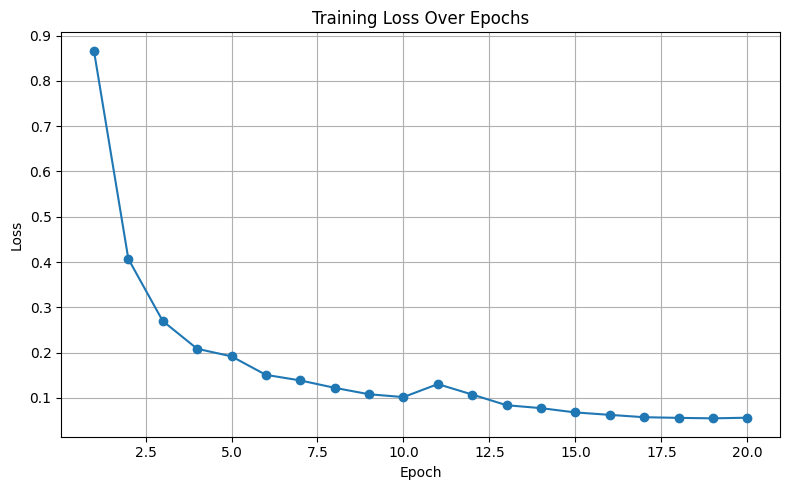

In [ ]:
#Print the loss curve

plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), loss_history, marker='o', linestyle='-')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import random
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision

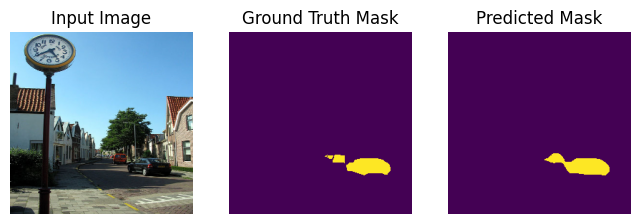

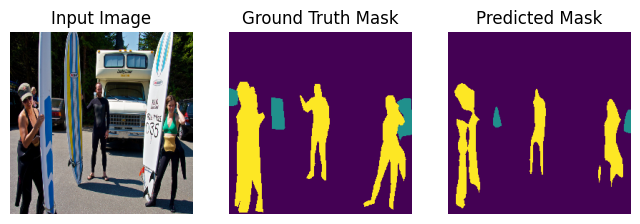

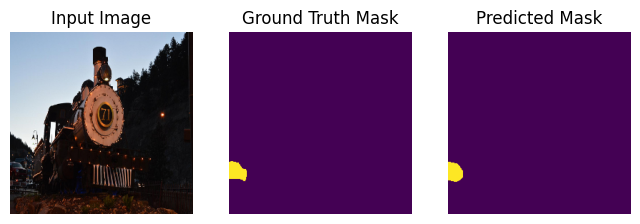

In [ ]:
def visualize_predictions(model, device, num_images=3):
    model.eval()
    image_files = sorted(os.listdir(output_img_dir))
    selected = random.sample(image_files, num_images)

    for img_name in selected:
        #Load image and mask
        img_path = os.path.join(output_img_dir, img_name)
        mask_path = os.path.join(output_mask_dir, img_name.replace(".png", "_mask.png"))

        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path)

        #Prepare input
        input_tensor = torchvision.transforms.ToTensor()(image).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_tensor)['out']
            pred_mask = torch.argmax(output.squeeze(), dim=0).cpu().numpy()

        #Plot
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title("Input Image")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(mask)
        plt.title("Ground Truth Mask")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask)
        plt.title("Predicted Mask")
        plt.axis('off')

        plt.show()

#Run visualization
visualize_predictions(model, device)

Calculate IOU and Dice

In [ ]:
import torch
from PIL import Image

In [ ]:
#Path to saved preprocessed images
output_img_dir = "/content/drive/MyDrive/preprocessed/images"

#List PNG files in that folder
image_files = [f for f in os.listdir(output_img_dir) if f.endswith(".png")]

#Print first few file names
print("Example image files:", image_files[:5])

Example image files: ['000000000149.png', '000000000260.png', '000000000328.png', '000000000419.png', '000000000722.png']


In [ ]:
#Load test image and mask

#Image from preprocessed
img_name = "000000000419.png"

#Load paths
img_path = os.path.join(output_img_dir, img_name)
mask_path = os.path.join(output_mask_dir, img_name.replace(".png", "_mask.png"))

# Load image and true mask
image = Image.open(img_path).convert('RGB')
true_mask = np.array(Image.open(mask_path))


In [ ]:
#Generate predictions

import torchvision.transforms as transforms
import torch

#Prepare input
input_tensor = transforms.ToTensor()(image).unsqueeze(0).to(device)

#Predict mask
model.eval()
with torch.no_grad():
    output = model(input_tensor)['out']
    pred_mask = torch.argmax(output.squeeze(), dim=0).cpu().numpy()

In [ ]:
#Define metrics

def compute_iou(pred_mask, true_mask, num_classes=5):
    ious = []
    for cls in range(1, num_classes):
        pred = (pred_mask == cls)
        truth = (true_mask == cls)
        intersection = np.logical_and(pred, truth).sum()
        union = np.logical_or(pred, truth).sum()
        if union == 0:
            ious.append(np.nan)
        else:
            ious.append(intersection / union)
    return np.nanmean(ious)

def compute_dice(pred_mask, true_mask, num_classes=5):
    dices = []
    for cls in range(1, num_classes):
        pred = (pred_mask == cls)
        truth = (true_mask == cls)
        intersection = 2 * np.logical_and(pred, truth).sum()
        total = pred.sum() + truth.sum()
        if total == 0:
            dices.append(np.nan)
        else:
            dices.append(intersection / total)
    return np.nanmean(dices)

iou = compute_iou(pred_mask, true_mask)
dice = compute_dice(pred_mask, true_mask)

print(f"IoU: {iou:.3f}, Dice: {dice:.3f}")

IoU: 0.358, Dice: 0.417


In [ ]:
import matplotlib.pyplot as plt

Evaluating: 000000000149.png
IoU: 0.184, Dice: 0.269


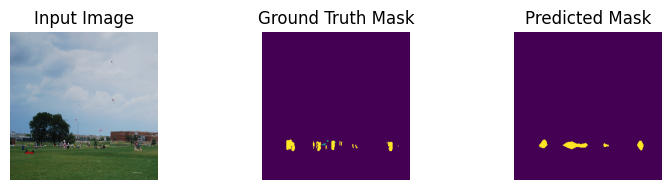

Evaluating: 000000000260.png
IoU: 0.306, Dice: 0.396


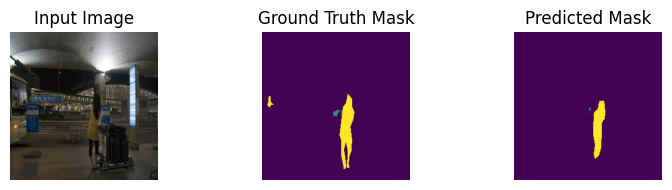

Evaluating: 000000000328.png
IoU: 0.085, Dice: 0.145


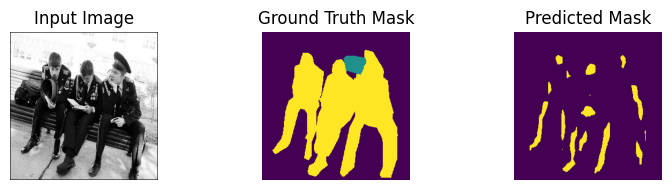

In [ ]:
def eval_mul_img(model, device, image_dir, mask_dir, num_images=3):
    model.eval()
    image_files = [f for f in os.listdir(image_dir) if f.endswith(".png")]
    image_files = image_files[:num_images]

    for img_name in image_files:
        print(f"Evaluating: {img_name}")

        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, img_name.replace(".png", "_mask.png"))

        #Load the image and true mask
        image = Image.open(img_path).convert('RGB')
        true_mask = np.array(Image.open(mask_path))

        #Prepare the input
        input_tensor = transforms.ToTensor()(image).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_tensor)['out']
            pred_mask = torch.argmax(output.squeeze(), dim=0).cpu().numpy()

        #Compute metrics
        iou = compute_iou(pred_mask, true_mask)
        dice = compute_dice(pred_mask, true_mask)
        print(f"IoU: {iou:.3f}, Dice: {dice:.3f}")

        #Visualize
        fig, axs = plt.subplots(1, 3, figsize=(8, 2))
        axs[0].imshow(image)
        axs[0].set_title("Input Image")
        axs[1].imshow(true_mask)
        axs[1].set_title("Ground Truth Mask")
        axs[2].imshow(pred_mask)
        axs[2].set_title("Predicted Mask")
        for ax in axs:
            ax.axis('off')
        plt.tight_layout()
        plt.show()

eval_mul_img(model, device, output_img_dir, output_mask_dir, num_images=3)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

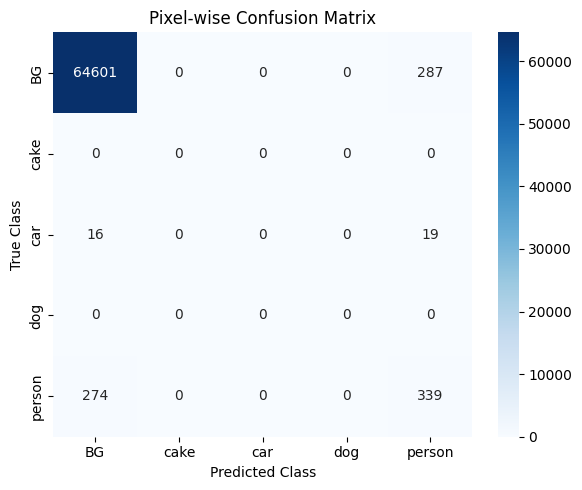

In [ ]:
from sklearn.metrics import confusion_matrix

def pixel_confusion_matrix(pred_mask, true_mask, class_names=None):
    if class_names is None:
        class_names = ["BG", "cake", "car", "dog", "person"]

    y_pred = pred_mask.flatten()
    y_true = true_mask.flatten()

    # Force all class indices to appear
    cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.title("Pixel-wise Confusion Matrix")
    plt.tight_layout()
    plt.show()

pixel_confusion_matrix(pred_mask, true_mask)

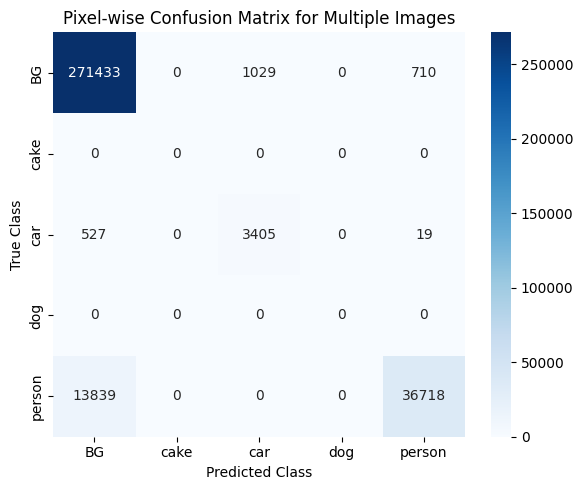

In [ ]:
#Check for multiple images

import glob
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Define the paths
image_paths = sorted(glob.glob(os.path.join(output_img_dir, "*.png")))
mask_paths = sorted(glob.glob(os.path.join(output_mask_dir, "*_mask.png")))

#Number of images to evaluate
eval_count = 5
all_preds = []
all_truths = []

#Check on multiple images

for img_path, mask_path in zip(image_paths[:eval_count], mask_paths[:eval_count]):
    image = Image.open(img_path).convert("RGB")
    mask = Image.open(mask_path)

    input_tensor = transforms.ToTensor()(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(input_tensor)['out']
        pred_mask = torch.argmax(output.squeeze(), dim=0).cpu().numpy()

    true_mask = np.array(mask)

    all_preds.append(pred_mask.flatten())
    all_truths.append(true_mask.flatten())

#Concatenate all predictions and truths
y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_truths)

#Compute confusion matrix
class_names = ["BG", "cake", "car", "dog", "person"]
cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))

#Plot

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Pixel-wise Confusion Matrix for Multiple Images")
plt.tight_layout()
plt.show()